In [1]:
!pip install pandas
!pip install transformers
!pip install torch
!pip install torchmetrics
!pip install spacy-udpipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 27.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 29.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.9/936.9 KB 51.6 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
from transformers import BertTokenizer, AutoTokenizer, BertForTokenClassification
from torch.utils.data import DataLoader, TensorDataset
import torchmetrics
from torchmetrics.classification import MulticlassF1Score, MulticlassPrecisionRecallCurve
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import torch
import torch.nn as nn
import transformers
import spacy_udpipe
import spacy

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
train_df = pd.read_csv("/content/gdrive/MyDrive/training-set-mm-02.csv")
test_df = pd.read_csv("/content/gdrive/MyDrive/test-set-mm-02.csv")
#val_df = pd.read_csv("/content/gdrive/MyDrive/bin-prelabeled-set2.csv")
train_data = train_df["instance"]
test_data = test_df["instance"]
train_labels = train_df["mm_transforms"]
test_labels = test_df["mm_transforms"]
#valid_data = val_df["instance"]
#valid_labels = val_df["bin_transforms"]

train_data = train_data.to_numpy()
train_labels = train_labels.to_numpy()
test_data = test_data.to_numpy()
test_labels = test_labels.to_numpy()
#valid_data = valid_data.to_numpy()
#valid_labels = valid_labels.to_numpy()
valid_data = train_data[50000:]
valid_labels = train_labels[50000:]
train_data = train_data[:50000]
train_labels = train_labels[:50000]
print(len(train_data), len(train_labels), len(test_data), len(test_labels), len(valid_data), len(valid_labels))

50000 50000 30000 30000 20000 20000


In [6]:
nlp = spacy.load("en_core_web_sm")

In [7]:
training_labels = []
testing_labels = []
val_labels = []
for each in train_labels:
  training_labels.append(each.replace(" ", ""))

for each in test_labels:
  testing_labels.append(each.replace(" ", ""))

for each in valid_labels:
  val_labels.append(each.replace(" ", ""))

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)
val_labels = np.array(val_labels)

In [8]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

In [9]:
label_map = {'0':0, "1":1, "2":2, "3":3, "4":4, "5":5, "6":6}

train_input_ids = []
test_input_ids = []
val_input_ids = []

for tokens in train_data:
    input_id = tokenizer.encode(tokens)
    train_input_ids.append(input_id)

for tokens in test_data:
    input_id = tokenizer.encode(tokens)
    test_input_ids.append(input_id)

for tokens in valid_data:
    input_id = tokenizer.encode(tokens)
    val_input_ids.append(input_id)


train_label_ids = [[label_map[label] for label in labels] for labels in training_labels]
test_label_ids = [[label_map[label] for label in labels] for labels in testing_labels]
val_label_ids = [[label_map[label] for label in labels] for labels in val_labels]

for i, (id, label) in enumerate(zip(train_input_ids, train_label_ids)):
    if len(id) > 512:
      train_input_ids[i] = id[:512]
      train_label_ids[i] = label[:512]

for i, (id, label) in enumerate(zip(test_input_ids, test_label_ids)):
    if len(id) > 512:
      test_input_ids[i] = id[:512]
      test_label_ids[i] = label[:512]

for i, (id, label) in enumerate(zip(val_input_ids, val_label_ids)):
    if len(id) > 512:
      val_input_ids[i] = id[:512]
      val_label_ids[i] = label[:512]

Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors


In [10]:
print(max([len(x) for x in train_label_ids]))  
max([len(x) for x in train_input_ids])

512


512

In [11]:
#testing block
temp1 = []
temp2 = []
for each1, each2 in zip(train_input_ids, train_label_ids):
  temp1.append(len(each1))
  temp2.append(len(each2))
temp1 == temp2

True

In [12]:
#testing block
x = 10
print(train_input_ids[x])
print(len(train_input_ids[x]))
print("-----")
print(train_label_ids[x])
print(len(train_label_ids[x]))

[101, 1284, 3523, 1107, 1395, 10423, 1477, 1248, 1837, 1268, 1807, 1103, 4528, 2927, 119, 102]
16
-----
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
16


In [13]:
train_input_ids = [torch.tensor(seq) for seq in train_input_ids]
train_input_ids = nn.utils.rnn.pad_sequence(train_input_ids, batch_first=True)

train_label_ids = [torch.tensor(seq) for seq in train_label_ids]
train_label_ids = nn.utils.rnn.pad_sequence(train_label_ids, batch_first=True, padding_value = -100)

test_input_ids = [torch.tensor(seq) for seq in test_input_ids]
test_input_ids = nn.utils.rnn.pad_sequence(test_input_ids, batch_first=True)

test_label_ids = [torch.tensor(seq) for seq in test_label_ids]
test_label_ids = nn.utils.rnn.pad_sequence(test_label_ids, batch_first=True, padding_value = -100)

val_input_ids = [torch.tensor(seq) for seq in val_input_ids]
val_input_ids = nn.utils.rnn.pad_sequence(val_input_ids, batch_first=True)

val_label_ids = [torch.tensor(seq) for seq in val_label_ids]
val_label_ids = nn.utils.rnn.pad_sequence(val_label_ids, batch_first=True, padding_value = -100)


# Create attention masks for the train dataset
train_attention_masks = []
#train_mask_labels = []
for seq, label in zip(train_input_ids, train_label_ids):
    seq_mask = [float(i>0) for i in seq]
    #seq_label = [float(i>0) for i in label]
    train_attention_masks.append(seq_mask)
    #train_mask_labels.append(seq_label)

# Create attention masks for the test dataset
test_attention_masks = []
#test_mask_labels = []
for seq, label in zip(test_input_ids, test_label_ids):
    seq_mask = [float(i>0) for i in seq]
    #seq_label = [float(i>0) for i in label]
    test_attention_masks.append(seq_mask)
    #test_mask_labels.append(seq_label)

# Create attention masks for the val dataset
val_attention_masks = []
#val_mask_labels = []
for seq, label in zip(val_input_ids, val_label_ids):
    seq_mask = [float(i>0) for i in seq]
    #seq_label = [float(i>0) for i in label]
    val_attention_masks.append(seq_mask)
    #val_mask_labels.append(seq_label)

In [14]:
train_attention_masks = torch.tensor(train_attention_masks)
test_attention_masks = torch.tensor(test_attention_masks)
val_attention_masks = torch.tensor(val_attention_masks)

In [15]:
test_label_ids[0]

tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -1

In [16]:
print(train_input_ids.shape, train_label_ids.shape, test_input_ids.shape, test_label_ids.shape)

torch.Size([50000, 512]) torch.Size([50000, 512]) torch.Size([30000, 438]) torch.Size([30000, 438])


In [17]:
train_input_ids = train_input_ids[:10000]
train_attention_masks = train_attention_masks[:10000]
train_label_ids = train_label_ids[:10000]
test_input_ids = test_input_ids[:4000]
test_attention_masks = test_attention_masks[:4000]
test_label_ids = test_label_ids[:4000]
#val_input_ids = val_input_ids[:2000]
#val_attention_masks = val_attention_masks[:2000]
#val_label_ids = val_label_ids[:2000]


In [18]:
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_label_ids)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_label_ids)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_label_ids)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=True)

In [19]:
torch.__version__

'1.13.1+cu116'

In [20]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [21]:
model = transformers.BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 2
transform_names = ["NO TRANSFORM", "MODAL", "INTENTION", "RESULT", "ASPECT", "STATUS", "MANNER"]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
epoch_losses = []
batch_losses = []
testing_loss = []
train_actuals = []
reports = []
train_preds = []
result_transform_p = []
result_transform_r = []
manner_transform_p = []
manner_transform_r = []
for epoch in range(epochs):
    total_loss = 0
    for i, (inputs, attention_masks, labels) in enumerate(train_loader):
        model.train()
        # Forward pass through the model
        #inputs, attention_masks = inputs.split(1, dim=-1)
        inputs, labels, attention_masks = inputs.to(device), labels.to(device), attention_masks.to(device)
        optimizer.zero_grad()
        #print(inputs.shape)
        #with torch.autograd.no_grad():
        output = model(inputs, attention_mask=attention_masks, labels=labels)

        loss = output.loss
        #print(output[0].shape)
        output = output[1]
        #print(output.shape)
        output = output.argmax(dim=-1)
        output = output.float()
        output = output.to(device)
        
            

        # Compute the loss
        labels = labels.float()
        
        temp_labels = labels[attention_masks == 1]
        temp_output = output[attention_masks == 1]


        predictions_np = list(temp_output.detach().cpu().numpy())
        labels_np = list(temp_labels.detach().cpu().numpy())
        train_actuals += labels_np
        train_preds += predictions_np
        
        #print(output.shape, labels.shape)
    
        
        #loss.requires_grad = True
            
        report = classification_report(train_actuals, train_preds, target_names=transform_names, output_dict=True)
        if (i + 1) % 200 == 0:
            print(report)
        # Backward pass and optimization step

        if "RESULT" in report:
              result_lemma_p = report['RESULT']['precision']
              result_lemma_r = report['RESULT']['recall']

        if "MANNER" in report:
              manner_lemma_p = report['MANNER']['precision']
              manner_lemma_r = report['MANNER']['recall']
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += float(loss.item())
        batch_losses.append(loss.item())
        if (i + 1) % 200 == 0:
            print(f"Loss is: {loss.item()}")
            print(result_lemma_p, result_lemma_r)
            print(manner_lemma_p, manner_lemma_r)
      
        reports.append(report)
        result_transform_p.append(result_lemma_p)
        manner_transform_p.append(manner_lemma_p)
        result_transform_r.append(result_lemma_r)
        manner_transform_r.append(manner_lemma_r)
    average_loss = total_loss / (i + 1)
    epoch_losses.append(average_loss)

        


    total = 0
    correct = 0
    f1_scores = []
    f1 = torchmetrics.F1Score(task='multiclass', num_classes=7).to(device)
    for inputs, attention_masks, labels in test_loader:
        # Forward pass through the model
        inputs, attention_masks, labels = inputs.to(device), attention_masks.to(device), labels.to(device)
        
        model.eval()

        with torch.no_grad():
            output = model(inputs, attention_mask=attention_masks, labels = labels)
            loss = output.loss
            output = output[1]
            output = output.argmax(dim=-1)
            output = output.float()
            output = output.to(device)
            #print(output.shape, labels.shape)

            temp_labels = labels[attention_masks == 1]
            temp_output = output[attention_masks == 1]
            #f1.update(temp_labels, temp_output)
        
        
            # Compute the loss
            labels = labels.float()
            testing_loss.append(loss)

        total += (labels.size(0) * len(labels[0]))
        correct += (output == labels).sum()
    accuracy = 100 * correct / total
    print('Loss: {}. F1: {}'.format(average_loss, f1.compute()))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

{'NO TRANSFORM': {'precision': 0.9915221497252747, 'recall': 0.9924167561761547, 'f1-score': 0.9919692512507784, 'support': 46550}, 'MODAL': {'precision': 0.6798866855524079, 'recall': 0.7453416149068323, 'f1-score': 0.7111111111111111, 'support': 322}, 'INTENTION': {'precision': 0.2736842105263158, 'recall': 0.40625, 'f1-score': 0.32704402515723274, 'support': 64}, 'RESULT': {'precision': 0.5, 'recall': 0.41964285714285715, 'f1-score': 0.45631067961165045, 'support': 112}, 'ASPECT': {'precision': 0.5, 'recall': 0.07407407407407407, 'f1-score': 0.12903225806451613, 'support': 27}, 'STATUS': {'precision': 0.9047619047619048, 'recall': 0.8285714285714286, 'f1-score': 0.8649921507064364, 'support': 665}, 'MANNER': {'precision': 0.19811320754716982, 'recall': 0.18584070796460178, 'f1-score': 0.19178082191780824, 'support': 113}, 'accuracy': 0.983929952145111, 'macro avg': {'precision': 0.5782811654447247, 'recall': 0.521733919833707, 'f1-score': 0.5246057568313619, 'support': 47853}, 'weig

/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MulticlassF1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Loss: 0.02955546382657485. F1: 0.0
{'NO TRANSFORM': {'precision': 0.9958128946111501, 'recall': 0.996726803224343, 'f1-score': 0.9962696393287094, 'support': 286570}, 'MODAL': {'precision': 0.8924680246328754, 'recall': 0.9119070667957405, 'f1-score': 0.9020828345702657, 'support': 2066}, 'INTENTION': {'precision': 0.7703703703703704, 'recall': 0.8062015503875969, 'f1-score': 0.787878787878788, 'support': 387}, 'RESULT': {'precision': 0.6680731364275668, 'recall': 0.7057949479940565, 'f1-score': 0.6864161849710984, 'support': 673}, 'ASPECT': {'precision': 0.8354430379746836, 'recall': 0.7374301675977654, 'f1-score': 0.7833827893175075, 'support': 179}, 'STATUS': {'precision': 0.9575113808801214, 'recall': 0.9505397941250314, 'f1-score': 0.9540128512032254, 'support': 3983}, 'MANNER': {'precision': 0.539553752535497, 'recall': 0.32961586121437425, 'f1-score': 0.4092307692307693, 'support': 807}, 'accuracy': 0.992608555478255, 'macro avg': {'precision': 0.8084617996331805, 'recall': 0.77

/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MulticlassF1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


2000


Text(0.5, 1.0, 'Average Vs Epoch')

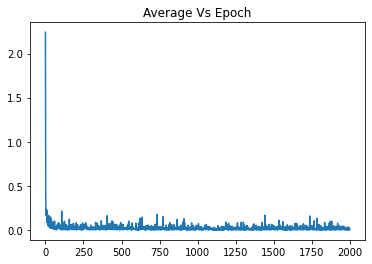

In [22]:
#Plot:
import matplotlib.pyplot as plt
print(len(batch_losses))
epochs = range(len(batch_losses))
plt.figure()
plt.plot(epochs, batch_losses, label='Loss')
plt.title('Average Vs Epoch')

800


TypeError: ignored

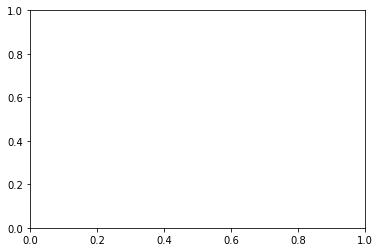

In [23]:
#Plot:
import matplotlib.pyplot as plt
print(len(testing_loss))
epochs = range(len(testing_loss))
plt.figure()
plt.plot(epochs, testing_loss, label='Loss')
plt.title('Average Vs Epoch')

2000


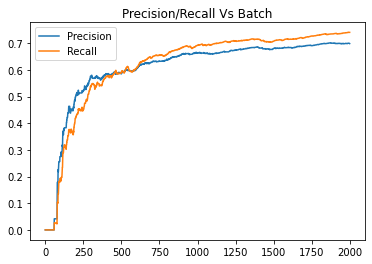

In [24]:
#Plot:
import matplotlib.pyplot as plt
print(len(result_transform_p))
epochs = range(len(result_transform_p))
plt.figure()
plt.plot(epochs, result_transform_p, label='Precision')
plt.plot(epochs, result_transform_r, label='Recall')
plt.title('Precision/Recall Vs Batch')
plt.legend()


2000


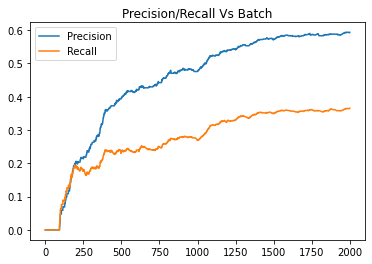

In [25]:
#Plot:
import matplotlib.pyplot as plt
print(len(manner_transform_p))
epochs = range(len(manner_transform_p))
plt.figure()
plt.plot(epochs, manner_transform_p, label='Precision')
plt.plot(epochs, manner_transform_r, label='Recall')
plt.title('Precision/Recall Vs Batch')
plt.legend()


In [26]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/mm_model_v2.pt')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = transformers.BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=7)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/mm_model_v2.pt', map_location=torch.device('cpu')))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

FileNotFoundError: ignored

In [27]:
total = 0
correct = 0
f1_scores = []
actuals = []
preds = []
#f1 = torchmetrics.F1Score(task='multiclass', num_classes=7).to(device)
metrics = []
#pr_curve = BinaryPrecisionRecallCurve(thresholds=[0.]).to(device)
for i, (inputs, attention_masks, labels) in enumerate(val_loader):
        # Forward pass through the model

        inputs, labels, attention_masks = inputs.to(device), labels.to(device), attention_masks.to(device)
        
        output = model(inputs, attention_mask=attention_masks)
        loss = output.loss
        output = output[0]
        output = output.argmax(dim=-1)
        output = output.float()
        output = output.to(device)

        labels = labels.float()
                        

        # Calculate F1 score
        temp_labels = labels[attention_masks == 1]
        temp_output = output[attention_masks == 1]


        predictions_np = list(temp_output.detach().cpu().numpy())
        labels_np = list(temp_labels.detach().cpu().numpy())
        actuals += labels_np
        preds += predictions_np

        #f1.update(temp_labels, temp_output)
        #pr_curve.update(temp_output, temp_labels)
        






        total += (labels.size(0) * len(labels[0]))
        correct += (output == labels).sum()
        #print(correct, total)
accuracy = 100 * correct / total
#print('Loss: {}. Accuracy: {}'.format(loss, accuracy))
#precisions, recalls, thresholds = pr_curve.compute()
#f1_score = f1.compute()
#print(f1_score)
#print(precisions)
#print(recalls)
#print(thresholds)
#print('F1 Score: {}. Precision: {}. Recall: {}.'.format(sum(f1_scores)/len(f1_scores), sum(precisions)/len(precisions), sum(recalls)/len(recalls)))

In [28]:
transform_names = ["NO TRANSFORM", "MODAL", "INTENTION", "RESULT", "ASPECT", "STATUS", "MANNER"]
report = classification_report(actuals, preds, target_names=transform_names)
print(report)

              precision    recall  f1-score   support

NO TRANSFORM       1.00      1.00      1.00    477580
       MODAL       0.99      0.90      0.94      3458
   INTENTION       0.95      0.95      0.95       589
      RESULT       0.75      0.83      0.79      1117
      ASPECT       0.97      0.83      0.90       289
      STATUS       0.96      0.99      0.98      6796
      MANNER       0.56      0.63      0.59      1325

    accuracy                           1.00    491154
   macro avg       0.88      0.88      0.88    491154
weighted avg       1.00      1.00      1.00    491154



In [29]:
example = "John is Here."
def process(example):
    input_ids = tokenizer.encode(example)
    if len(input_ids) > 512:
      input_ids = input_ids[:512]
    #print(example)
    example = [torch.tensor(seq) for seq in input_ids]
    example = [example]
    example = torch.tensor(example)
    #padded = nn.utils.rnn.pad_sequence(torch.tensor(example), batch_first=True)
    #mask = [float(i>0) for i in padded]
    #mask = mask.to(device)
    #padded = padded.to(device)
    example = example.to(device)
    output = model(example)
    output = output.logits
    output = output.argmax(dim=-1)
    output = output.float()
    output = output.tolist()[0]
    output = list(map(int, output))
    return output

print(process(example))

[0, 0, 0, 0, 0, 0]


In [30]:
counter = 0
for i, (instance, actual) in enumerate(zip(valid_data, val_labels)):
    actual = list(actual)
    actual = list(map(int, actual))
    predicted = process(instance)
    actual = actual[1: len(actual) - 1]
    predicted = predicted[1: len(predicted) - 1]
    inst_tokens = tokenizer.tokenize(instance)
    predicted = [(tok, inst_tokens[ind]) if i != 0 else (tok) for ind, tok in enumerate(predicted)]
    actual = [(tok, inst_tokens[ind]) if i != 0 else (tok) for ind, tok in enumerate(actual)]
    if predicted != actual:
      counter += 1
      print(i, instance)
      print("Predicted", predicted)
      print("actual   ", actual)
      print("---------")
  #["NO TRANSFORM", "MODAL", "INTENTION", "RESULT", "ASPECT", "STATUS", "MANNER"]

Streaming output truncated to the last 5000 lines.
7732 It is not a 4 start as advertised though.
Predicted [(0, 'It'), (0, 'is'), (5, 'not'), (0, 'a'), (0, '4'), (4, 'start'), (0, 'as'), (0, 'advertised'), (0, 'though'), (0, '.')]
actual    [(0, 'It'), (0, 'is'), (5, 'not'), (0, 'a'), (0, '4'), (0, 'start'), (0, 'as'), (0, 'advertised'), (0, 'though'), (0, '.')]
---------
7734 Lastly, I notified management the next morning and they seemed surprised and didn't even apologize.
Predicted [(0, 'Last'), (0, '##ly'), (0, ','), (0, 'I'), (0, 'notified'), (0, 'management'), (0, 'the'), (0, 'next'), (0, 'morning'), (0, 'and'), (0, 'they'), (0, 'seemed'), (6, 'surprised'), (0, 'and'), (5, 'didn'), (5, "'"), (5, 't'), (0, 'even'), (0, 'apologize'), (0, '.')]
actual    [(0, 'Last'), (0, '##ly'), (0, ','), (0, 'I'), (0, 'notified'), (0, 'management'), (0, 'the'), (0, 'next'), (0, 'morning'), (0, 'and'), (0, 'they'), (0, 'seemed'), (0, 'surprised'), (0, 'and'), (5, 'didn'), (5, "'"), (5, 't'), (0, 

In [31]:
print(counter)
print(f"Sequence Level Validation Accuracy: {round(100 * (1 - (counter / len(valid_data))), 2)}%")

1993
Sequence Level Validation Accuracy: 90.03%
